# Chain using LangGraph

LangGraph uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in out graph nodes

In [63]:
from dotenv import load_dotenv

load_dotenv()

import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

# How to use chat messages a out graph state

Messages

We can use messages which can be used to capture different roles with in a conversation. LangChain has various message typed incliding HumanMessage, AIMessage, SystemMessage and ToolMessage. These represent a message from the user, from chat model, 

Every message have these important components.

- content- content of the message
- name- Specify the name of author
- response_metadata - Optionally, a dict of metadata (eg., often populated by model provider for AIMessages)


In [64]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint # this lib is to print in beautiful manner (pretty print)

messages = [AIMessage(content=f"Please tellme how can I help", name="LLM-Model")]
messages.append(HumanMessage(content=f"I want to learn coding!", name="BoonSai"))
messages.append(AIMessage(content=f"Which programming languge you want to learn", name="LLM-Model"))
messages.append(HumanMessage(content=f"Hey! I want to learn python programming langugae", name="BoonSai"))

for message in messages: message.pretty_print()


================================== Ai Message ==================================
Name: LLM-Model

Please tellme how can I help
================================ Human Message =================================
Name: BoonSai

I want to learn coding!
================================== Ai Message ==================================
Name: LLM-Model

Which programming languge you want to learn
================================ Human Message =================================
Name: BoonSai

Hey! I want to learn python programming langugae


# Chat models

We can use the sequence of messages a input with the chat-models using LLM's

In [65]:
from langchain_groq import ChatGroq

llm = ChatGroq(model = 'llama-3.1-8b-instant')
result = llm.invoke(messages)

In [66]:
result.response_metadata # it prints metadata of the llm's output

{'token_usage': {'completion_tokens': 434,
  'prompt_tokens': 82,
  'total_tokens': 516,
  'completion_time': 0.596568943,
  'prompt_time': 0.005069205,
  'queue_time': 0.044475845,
  'total_time': 0.601638148},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_e32974efee',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

# Tools

-Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools. 

- Whenever a query is asked the model can choose to call the tool and this query is based on the natural language input and this will return and output that matches the tool's schema

In [67]:
def add(a: int, b:int)-> int:
    """ Add a and b
    Args:
        a (int): First int
        b (int): second int
    
    returns:
        int     
    """
    return a+b 

In [68]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10f44c1d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10f0a1c90>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [70]:
## Binding tool with llm

llm_with_tools = llm.bind_tools([add])

tool_call = llm_with_tools.invoke([HumanMessage(content=f"what is 2 plus 2", name='BoonSai')]) # here it shows empty message 

Here the content='', i.e the content is blank, there is no response from AI message. instead there is a additional parameter i.e 'name' : 'add',

that means it calls the add tool call/ functionality

In [71]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'e5axgzc8d',
  'type': 'tool_call'}]

### using messages as state

In [72]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class state(TypedDict):
    message: list[AnyMessage]

### Reducers
Now, we have a minor problem!

As we discuessed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As out graph runs, we want to append messages to out messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-build add_messages reducer.

This ensure that any messages are appended to the existing list of messages.

We simply need to annotate out messages key with the add_messages reducer function as metadata.

In [73]:
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages: Annotated[list[add_messages], add_messages]

## Reducers with add_message


In [74]:
initial_messages = [AIMessage(content=f'Please tell me how can I help', name='LLM-Model')]
initial_messages.append(HumanMessage(content=f'I want to learn coding', name='Krish'))

In [75]:
ai_message = AIMessage(content=f"Which programming languge you want to learn", name="LLM-Model")
ai_message

AIMessage(content='Which programming languge you want to learn', additional_kwargs={}, response_metadata={}, name='LLM-Model')

In [76]:
# Reducers add_messages is to append instead of override
add_messages(initial_messages, ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLM-Model', id='c253c784-ddfd-49ba-83c3-f337f91ba2d7'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish', id='86561fc8-a9cb-497b-9fed-8abef5600d08'),
 AIMessage(content='Which programming languge you want to learn', additional_kwargs={}, response_metadata={}, name='LLM-Model', id='671e1413-365d-46d6-8948-ebac4cd75c24')]

In [81]:
# chatbot node functionality
def llm_tool(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

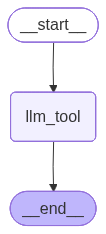

In [82]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)

builder.add_edge(START, "llm_tool")
builder.add_edge('llm_tool', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [83]:
## Invocation

messages = graph.invoke({"messages": "what is 2 plus 2"})
for msg in messages['messages']:
    msg.pretty_print()

================================ Human Message =================================

what is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (dcqn6whw5)
 Call ID: dcqn6whw5
  Args:
    a: 2
    b: 2
